# Object Detection with RetinaNet

**Author:** [Giuseppe Tripodi](https://www.linkedin.com/in/giuseppe-tripodi-unical/)<br>
**Date created:** 2022/06/23<br>
**Description:** Object Detection with RetinaNet on historical Data.

# Introduction

Object Detection is a important problem in computer vision. In this notebook, we implement [PyTorch RetinaNet](https://github.com/benihime91) for custom dataset. 


**References**:
- [gitHub-RetinaNet-Demo.ipynb](https://colab.research.google.com/github/benihime91/pytorch_retinanet/blob/master/demo.ipynb)- the following notebook is adapter starting from this one

## Information to run the notebook 

To run the notebook, proceed as follows
1. clone the repository on your device
2. open each notebook on [Google Colab](https://research.google.com/colaboratory/)
3. copy the following directory ,that you can find on the repository, to your [Google Drive](https://drive.google.com/drive/my-drive) (directories must be placed under the "MyDrive" directory)
  - "dataset"
  - "configuration_file_SUS_project"

You can now run each notebook without any problems.

## Note

To obtain the results presented in the paper, it is necessary to upload the directory with the trained weights (the name of the directory is WEIGHTS) together with a complete dataset to Drive.

The WEIGHTS directory have the following structure and contain the trained weights for each model:

```
WEIGHTS
└─── YOLOR
|   └─── yolor-p6-not-random-weights-300-epochs
|   |   └─── weights
|   |   |   └─── best.pt
└─── YOLOX
|   └─── best.pt
|   |   └─── best_ckpt.pth
└─── RETINA_NET
|   └─── best_ckpt.pth
```

Since the loaded dataset is only a sample, there are only a few test images in the test_set folder. It will therefore only be possible to make inferences. To train the model, it is necessary to add the complete dataset with the structure defined below.

Note that to run the model, the training part must be uncommented.

# Run the notebook on custom dataset

In order to run the notebook on custom dataset you need to organize the configuration directory in the following way:

```
dataset
└─── original dataset
|   |
|   └─── images
|   |   |
|   |   └─── test_dir
|   |   └─── train_dir
|   |   └─── val_dir
|   |
|   |
configuration_file_SUS_project
|
└─── YOLOX
|    train2017.json
|    test2017.json
|    val2017.json
```
The name of the directory must be the same as the one presented above.

Under images each directory contains all the images used as training, validation and test sets. Under configuration_file_SUS_project we have the labels from each set in the proper format. The file are created with the script `script/dataset_to_coco.py`. \\
The image and its labels  file must have the same name.


# Setup

## Setting up Colab :

In [ ]:
# Ensure colab doesn't disconnect
%%javascript
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}setInterval(ClickConnect,60000)

<IPython.core.display.Javascript object>

In [ ]:
#connect to google drive and get the  dataset
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


## Install Pytorch Retinanet and Dependencies

In [ ]:
!pip install -Uqq pytorch-lightning==1.0.0 omegaconf
!pip install -Uqq git+https://github.com/albumentations-team/albumentations
!pip uninstall -y torchtext
!git clone https://github.com/benihime91/pytorch_retinanet.git

     |████████████████████████████████| 510 kB 5.2 MB/s 
     |████████████████████████████████| 79 kB 8.1 MB/s 
     |████████████████████████████████| 140 kB 65.2 MB/s 
     |████████████████████████████████| 829 kB 67.7 MB/s 
     |████████████████████████████████| 596 kB 59.1 MB/s 
     |████████████████████████████████| 117 kB 43.7 MB/s 
     |████████████████████████████████| 48.3 MB 2.0 MB/s 
Found existing installation: torchtext 0.12.0
Uninstalling torchtext-0.12.0:
  Successfully uninstalled torchtext-0.12.0
Cloning into 'pytorch_retinanet'...
remote: Enumerating objects: 2137, done.
remote: Counting objects: 100% (105/105), done.
remote: Compressing objects: 100% (90/90), done.
remote: Total 2137 (delta 56), reused 32 (delta 15), pack-reused 2032
Receiving objects: 100% (2137/2137), 84.65 MiB | 25.15 MiB/s, done.
Resolving deltas: 100% (1406/1406), done.


In [ ]:
!pip uninstall -y opencv-python
!pip install opencv-python
import cv2

Found existing installation: opencv-python 4.1.2.30
Uninstalling opencv-python-4.1.2.30:
  Successfully uninstalled opencv-python-4.1.2.30
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 60.9 MB 1.2 MB/s 


In [ ]:
#Update sys path to include the pytorch RetinaNet modules
import warnings
import os
import sys
import json
import pandas as pd
import json
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import callbacks, metrics

import pandas as pd
from PIL import Image
import cv2
import numpy as np

pd.set_option("display.max_colwidth", None)
np.random.seed(123)

warnings.filterwarnings('ignore')
sys.path.append("/content/pytorch_retinanet/")
%load_ext autoreload
%autoreload 2
%matplotlib inline

## Support Function

In [ ]:
def convert_annotations_to_df(ANNOT_PATH, IMAGE_PATH):
  #define the category dict
  cat_dict = {1 :"tank", 2:"car", 3:"truck",  4:"boat", 5:"airplane", 6:"horse trailer", 7:"train", 8:"motorcycle" ,  9:"Unknow"}

  f = open(ANNOT_PATH)
  json_ = json.load(f)
  df_images = pd.DataFrame.from_dict(json_["images"])
  df_annotations = pd.DataFrame.from_dict(json_["annotations"])

  # create dataframe with the bounding box information
  dt = {}
  for index, row in df_annotations.iterrows():
    dt[index] = row["bbox"]
  df = pd.DataFrame.from_dict(dt, orient="index")
  # the column represent = 0:left, 1:top, 2:width, 3:height
  # I do the transformation as= 0:x_min, 1:y_min, 2:x_max, 3:y_max
  df.rename(columns = {0:"xmin", 1:"ymin", 2:"xmax", 3:"ymax"}, inplace= True)

  #merge the two dataframe
  df_annotations = pd.merge(df_annotations, df, left_index=True, right_index=True)
  df_annotations.drop(["area", "segmentation" , "iscrowd", "bbox", "id"], axis = 1, inplace = True)

  #add the category labels information
  df_annotations["class"] = df_annotations.apply(lambda row: cat_dict[row["category_id"]], axis=1)

  #join the images based on the id column
  #df_images = pd.merge(df_annotations, df_images, left_index=True, right_index=True)
  df_images = pd.merge(df_annotations, df_images, left_on="image_id", right_on="id")
  
  #change the filename information to contain the correct directory
  dt = {}
  for index, row in df_images.iterrows():
    dt[index] = f"{IMAGE_PATH}{row['file_name']}"
  df = pd.DataFrame.from_dict(dt, orient="index")
  df_images = pd.merge(df_images, df, left_index=True, right_index=True)


  df_images.drop(["image_id", "id", "file_name"], axis = 1, inplace=True)
  #modify some column
  df_images.rename(columns = {0:"filename", "category_id":"labels"}, inplace=True)

  return df_images   

In [ ]:
from utils import visualize_boxes_and_labels_on_image_array as viz_bbs
import matplotlib.pyplot as plt


def grab_bbs_(dataframe, index:int):
    """
    Takes in a Pandas DataFrame and a index number
    Returns filename of the image and all the bounding boxes and class_labels
    corresponding the image that is at the given index

    Params
    ------
        dataframe : a pandas dataframe object
        index (int) : a integer corresponding to a index in the pandas dataframe

    Returns
    -------
        fname (str) : path to the selected image.
        bbbs (list) : a list containing the bounding box annotations for the `fname`.
        cls (list) : a list containing the integer class labels for the box annotations.  
    """
    assert index <= len(dataframe), f"Invalid index for dataframe with len: {len(dataframe)}"
    fname = dataframe.filename[index]
    locs  = dataframe.loc[dataframe.filename == fname]
    bbs   = locs[["xmin", "ymin", "xmax", "ymax"]].values
    cls   = locs["labels"].values
    return fname, bbs, cls

def load_image_from_data(dataframe, index):
    """
    Loads in a image from the given dataframe at given index
    Returns a PIL image object contraining all the bounding boxes over
    the image
    """
    image, boxes, clas = grab_bbs_(dataframe, index)
    #load and normalize the image
    image = Image.open(image)
    image = np.array(image) / 255.
    image = viz_bbs(image, boxes, scores=None, classes=clas, label_map=LABEL_MAP)
    return image

In [ ]:
#given a dataframe the method delete the functions that are not present in the image directory
def del_notpresent_images(df):
    for ind in df.index:
        if not os.path.isfile(df['filename'][ind]):
            df = df.drop(ind)
    return df

# Prepare Pytorch Retinanet Object Detection Training Data

Set up paths 

In [ ]:
#Path to where the Images are stored
TRAIN_IMAGE_PATH = "/content/train/"
VALID_IMAGE_PATH = "/content/valid/"
TEST_IMAGE_PATH  = "/content/test/"
#Path to where annotations are stored
TRAIN_ANNOT_PATH = "/content/annotations/train/"
VALID_ANNOT_PATH = "/content/annotations/valid/"
TEST_ANNOT_PATH  = "/content/annotations/test/"

In [ ]:
# create all the directory
!mkdir annotations
!mkdir {TRAIN_IMAGE_PATH}
!mkdir {VALID_IMAGE_PATH}
!mkdir {TEST_IMAGE_PATH}
!mkdir {TRAIN_ANNOT_PATH}
!mkdir {VALID_ANNOT_PATH}
!mkdir {TEST_ANNOT_PATH}

#copy the test, train and val file
!cp -r /content/gdrive/MyDrive/dataset/original_dataset/images/test_dir/* {TEST_IMAGE_PATH}
!cp -r /content/gdrive/MyDrive/dataset/original_dataset/images/train_dir/* {TRAIN_IMAGE_PATH}
!cp -r /content/gdrive/MyDrive/dataset/original_dataset/images/val_dir/* {VALID_IMAGE_PATH}


## Generate dataframe file from JSON Annotations:

The json annotation file are created with the script `script/dataset_to_coco.py`

In [ ]:
train_annotations_json_file = "/content/gdrive/MyDrive/configuration_file_SUS_project/YOLOX/train2017.json"
test_annotations_json_file = "/content/gdrive/MyDrive/configuration_file_SUS_project/YOLOX/test2017.json"
val_annotations_json_file = "/content/gdrive/MyDrive/configuration_file_SUS_project/YOLOX/val2017.json"

#convert JSON files to pandas DataFrames
train_df = convert_annotations_to_df(train_annotations_json_file,TRAIN_IMAGE_PATH  )
valid_df = convert_annotations_to_df(val_annotations_json_file, VALID_IMAGE_PATH)
test_df  = convert_annotations_to_df(test_annotations_json_file, TEST_IMAGE_PATH )


In [ ]:
def remove_invalid_annots(df):
    """
    Removes annotations where xmax, ymax < xmin,ymin
    from the given dataframe
    """
    df = df[df.xmax > df.xmin]
    df = df[df.ymax > df.ymin]
    df.reset_index(inplace=True, drop=True)
    return df

# removing annotations that are not valid annotations
train_df = remove_invalid_annots(train_df)
valid_df = remove_invalid_annots(valid_df)
test_df  = remove_invalid_annots(test_df)

#remove rows with not present images
train_df = del_notpresent_images(train_df)
valid_df = del_notpresent_images(valid_df)
test_df  = del_notpresent_images(test_df)


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 611 entries, 0 to 610
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   labels    611 non-null    int64  
 1   xmin      611 non-null    float64
 2   ymin      611 non-null    float64
 3   xmax      611 non-null    float64
 4   ymax      611 non-null    float64
 5   class     611 non-null    object 
 6   height    611 non-null    int64  
 7   width     611 non-null    int64  
 8   filename  611 non-null    object 
dtypes: float64(4), int64(3), object(2)
memory usage: 43.1+ KB


In [ ]:
valid_df.head()

,labels,xmin,ymin,xmax,ymax,class,height,width,filename
0,1,97.647277,0.000000,1170.000088,1054.588271,tank,1080,1440,/content/valid/8452_(NARA_LID-111-SFR-53-R03_MPPC_NAID-36151_OFMID-1603892600524_H264_1440x1080_AAC-stereo_24fps_12Mbit_GOP01_crop_AC_VHH-P_OFM_2022-01-12_sid_73_pos_6532_LS.png
1,2,86.104191,422.759385,328.509000,702.288805,car,1080,1440,/content/valid/8452_(NARA_LID-111-SFR-53-R03_MPPC_NAID-36151_OFMID-1603892600524_H264_1440x1080_AAC-stereo_24fps_12Mbit_GOP01_crop_AC_VHH-P_OFM_2022-01-12_sid_3_pos_189_ELS.png
2,6,694.424885,420.449215,1137.679412,868.620374,horse trailer,1080,1440,/content/valid/8451_(NARA_LID-111-ADC-4319_DNS_NAID-18121_OFMID-1603892773159_H264_1440x1080_AAC-stereo_24fps_12Mbit_GOP01_uncrop_AC-VHH-P_OFM_2022-01-16_sid_73_pos_6535_ELS.png
3,6,732.517016,440.085588,1196.549045,919.443833,horse trailer,1080,1440,/content/valid/8451_(NARA_LID-111-ADC-4319_DNS_NAID-18121_OFMID-1603892773159_H264_1440x1080_AAC-stereo_24fps_12Mbit_GOP01_uncrop_AC-VHH-P_OFM_2022-01-16_sid_72_pos_6429_ELS.png
4,6,1075.346729,377.711239,1440.000000,1074.224599,horse trailer,1080,1440,/content/valid/8451_(NARA_LID-111-ADC-4319_DNS_NAID-18121_OFMID-1603892773159_H264_1440x1080_AAC-stereo_24fps_12Mbit_GOP01_uncrop_AC-VHH-P_OFM_2022-01-16_sid_72_pos_6429_ELS.png


In [ ]:
test_df.head()

,labels,xmin,ymin,xmax,ymax,class,height,width,filename
0,1,0.000000,40.427807,1440.000000,1080.000000,tank,1080,1440,/content/test/8449_(NARA_LID-208-UN-1050_FGMC_NAID-39167_OFMID-1603891809037_H264_1440x1080_AAC-stereo_24fps_12Mbit_GOP01_crop_AC-VHH-P_OFM_2021-12-18_sid_85_pos_8203_LS.png
1,1,0.685380,363.850267,924.132229,1071.914474,tank,1080,1440,/content/test/8449_(NARA_LID-208-UN-1050_FGMC_NAID-39167_OFMID-1603891809037_H264_1440x1080_AAC-stereo_24fps_12Mbit_GOP01_crop_AC-VHH-P_OFM_2021-12-18_sid_84_pos_8115_ELS.png
2,2,0.000000,93.561502,1198.857803,1055.743333,car,1080,1440,/content/test/8449_(NARA_LID-208-UN-1050_FGMC_NAID-39167_OFMID-1603891809037_H264_1440x1080_AAC-stereo_24fps_12Mbit_GOP01_crop_AC-VHH-P_OFM_2021-12-18_sid_21_pos_1303_LS.png
3,3,834.096210,442.395713,1058.032099,695.358342,truck,1080,1440,/content/test/8418_(NARA_LID-111-ADC-4229_DNS_NAID-18031_OFMID-1603890649208_H264_1440x1080_MOS_24fps_12Mbit_GOP01_uncrop_AC-VHH-P_OFM_2021-11-11_sid_73_pos_13388_ELS.png
4,1,245.398771,279.529421,854.873712,859.379697,tank,1080,1440,/content/test/8418_(NARA_LID-111-ADC-4229_DNS_NAID-18031_OFMID-1603890649208_H264_1440x1080_MOS_24fps_12Mbit_GOP01_uncrop_AC-VHH-P_OFM_2021-11-11_sid_71_pos_12733_LS.png


### CSV Files are as follows :

In [ ]:
#Paths where to save the generated dataframes
TRAIN_CSV = "/content/train_data.csv"
VALID_CSV = "/content/valid_data.csv"
TEST_CSV  = "/content/test_data.csv"

# #Save the dataframes to memory
train_df.to_csv(TRAIN_CSV, index=False)
valid_df.to_csv(VALID_CSV, index=False)
test_df.to_csv(TEST_CSV, index=False)

In [ ]:
train_df = pd.read_csv(TRAIN_CSV)
valid_df = pd.read_csv(VALID_CSV)
test_df  = pd.read_csv(TEST_CSV)

# View Images from the Dataset:

We can use the fn `visualize_boxes_and_labels_on_image_array` from the RetinaNet repo to visualize images and the bounding boxes over them. To use this function we need to first create a Label Map, which is a list that contains all the classes at index corresponding to the integer labels .

In [ ]:
##Let's now generate the Label Map which is used for visualization:**

from utils.pascal import generate_pascal_category_names

#LABEL_MAP = generate_pascal_category_names(train_df)
LABEL_MAP = {1 :"tank", 2:"car", 3:"truck",  4:"boat", 5:"airplane", 6:"horse trailer", 7:"train", 8:"motorcycle" ,  9:"Unknow"}

Plot images with Bounding boxes over them:

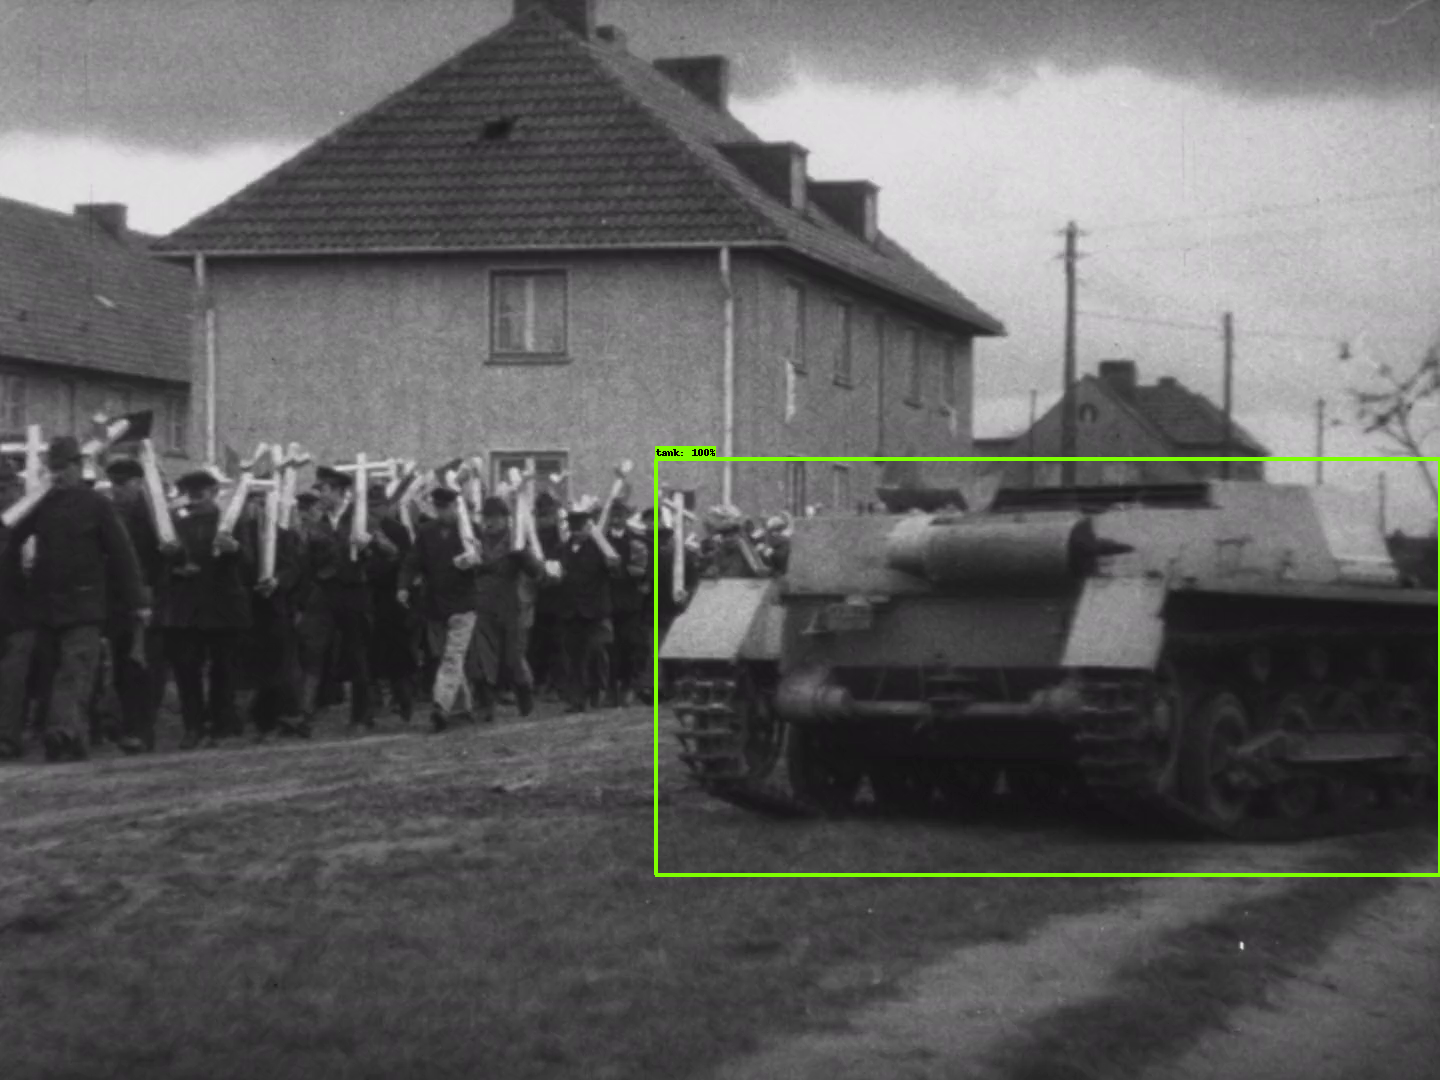

In [ ]:
image = load_image_from_data(test_df, index=1)
image

# Training The Model

## Configure Custom PyTorch RetianNet Object Detection Training Configuration :

The configuration file is present in `/content/pytorch_retinanet/hparams.yaml`.


In [ ]:
NUM_TRAIN_EPOCHS = 300


from omegaconf import OmegaConf

#load in the hparams.ymal file using Omegaconf
hparams = OmegaConf.load("/content/pytorch_retinanet/hparams.yaml")

# ========================================================================= #
# MODIFICATION OF THE CONFIG FILE TO FIX PATHS AND DATSET-ARGUEMENTS :
# ========================================================================= #
hparams.dataset.kind        = "csv"
hparams.dataset.trn_paths   = TRAIN_CSV
hparams.dataset.valid_paths = VALID_CSV
hparams.dataset.test_paths  = TEST_CSV

#batch size
hparams.dataloader.train_bs = 4
hparams.dataloader.valid_bs = 16
hparams.dataloader.test_bs  = 16

hparams.model.num_classes   = len(LABEL_MAP)  
hparams.model.backbone_kind = "resnet34"
hparams.model.min_size      = 800
hparams.model.max_size      = 1333
hparams.model.pretrained    = True #loads in imagenet-backbone weights

#transforms for the train_dataset
hparams.transforms  =  [
    {"class_name": "albumentations.HorizontalFlip", "params": {"p": 0.5} },
    {"class_name": "albumentations.ShiftScaleRotate", "params": {"p": 0.5} },
    {"class_name": "albumentations.RandomBrightnessContrast", "params": {"p": 0.5} },
]

#optimizer
hparams.optimizer = {
    "class_name": "torch.optim.SGD", 
    "params"    : {"lr": 0.001, "weight_decay": 0.0005, "momentum":0.9},
    }

#scheduler
hparams.scheduler = {
    "class_name" : "torch.optim.lr_scheduler.CosineAnnealingLR", 
    "params"     : {"T_max": NUM_TRAIN_EPOCHS}, 
    "monitor"    : None, 
    "interval"   : "epoch", 
    "frequency"  : 1
    }

print(OmegaConf.to_yaml(hparams))

model:
  backbone_kind: resnet34
  num_classes: 9
  freeze_bn: true
  min_size: 800
  max_size: 1333
  pretrained: true
dataset:
  kind: csv
  root_dir: false
  trn_paths: /content/train_data.csv
  valid_paths: /content/valid_data.csv
  test_paths: /content/test_data.csv
dataloader:
  train_bs: 4
  valid_bs: 16
  test_bs: 16
  args:
    num_workers: 0
    pin_memory: true
transforms:
- class_name: albumentations.HorizontalFlip
  params:
    p: 0.5
- class_name: albumentations.ShiftScaleRotate
  params:
    p: 0.5
- class_name: albumentations.RandomBrightnessContrast
  params:
    p: 0.5
optimizer:
  class_name: torch.optim.SGD
  params:
    lr: 0.001
    weight_decay: 0.0005
    momentum: 0.9
scheduler:
  class_name: torch.optim.lr_scheduler.CosineAnnealingLR
  params:
    T_max: 300
  monitor: null
  interval: epoch
  frequency: 1



## Instantiate Lightning-Module and Lightning-Trainer

In [ ]:
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import LearningRateMonitor, EarlyStopping



In [ ]:
#solve the error in file backbone.py line 6
!sed -i '6s/.*/from torch.hub import load_state_dict_from_url/' /content/pytorch_retinanet/retinanet/backbone.py

#add a code in the file transform.py





In [ ]:
from model import RetinaNetModel

# seed so that results are reproducible
pl.seed_everything(123)

#TODO solve the error in backbone.py, devi modificare la riga 6 ed aggiungere:
# from torch.hub import load_state_dict_from_url
#piuttosto che quello che c'è già

[autoreload of torchvision.models.detection.transform failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
  File "/usr/local/lib/python3.7/dist-packages/torchvision/models/detection/transform.py", line 296
    xmin, ymin, xmax, ymax = boxes.unbind(1)
                                           ^
TabError: inconsistent use of tabs and spaces in indentation
]


123

In [ ]:
#set another checkpoint

PROJECT = "/content/gdrive/MyDrive/WEIGHTS/" # directory to use to save weights
MODEL_NAME = "RETINA_NET"
EXPERIMENT_NAME = "batch_2"

#create the directory
!mkdir {PROJECT}/{MODEL_NAME}/{EXPERIMENT_NAME}

[autoreload of torchvision.models.detection.transform failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
  File "/usr/local/lib/python3.7/dist-packages/torchvision/models/detection/transform.py", line 296
    xmin, ymin, xmax, ymax = boxes.unbind(1)
                                           ^
TabError: inconsistent use of tabs and spaces in indentation
]


mkdir: cannot create directory ‘/content/gdrive/MyDrive/WEIGHTS//RETINA_NET/batch_2’: File exists


In [ ]:
# ============================================================ #
# INSTANTIATE LIGHTNING-TRAINER with CALLBACKS :
# ============================================================ #
# NOTE: 
# For a list of whole trainer specific arguments see : 
# https://pytorch-lightning.readthedocs.io/en/latest/trainer.html

lr_logger  = LearningRateMonitor(logging_interval="step")

#instantiate LightningTrainer
trainer    = Trainer(precision=16, gpus=1, callbacks=[lr_logger], max_epochs=NUM_TRAIN_EPOCHS, default_root_dir="{PROJECT}/{MODEL_NAME}/{EXPERIMENT_NAME}")

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.


##Load in the Lighning-Module using the hparams file modified above & Start Train :

In [ ]:
# Instantiate lightning-module
litModel = RetinaNetModel(conf=hparams)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

BACKBONE     : resnet34
INPUT_PARAMS : MAX_SIZE=1333, MIN_SIZE=800
NUM_CLASSES  : 9


Uncomment the following part if you wanto to train the model.

In [ ]:
#trainer.fit(litModel)


  | Name | Type      | Params
-----------------------------------
0 | net  | Retinanet | 30 M  


Validation sanity check: 0it [00:00, ?it/s]

Training: 67it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

1

# Evaluating the trained-model using COCO-API Metrics : 

In order to test the model with this tool you need train the model first.

In [ ]:
#trainer.test(litModel)

creating index...
index created!


Testing: 0it [00:00, ?it/s]

Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.504
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.967
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.203
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.504
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.440
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.540
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.540
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=

[{'AP': 0.5037953795379538}]

## Export the model weights :

Decomment this part if you want to save your trained weight.

In [ ]:
'''
import torch
model_name = "weight_300.pt"
PATH = f"/content/gdrive/MyDrive/WEIGHTS/RETINA_NET/{model_name}"
torch.save(litModel.net.state_dict(), PATH)
'''

'\nimport torch\nmodel_name = "weight_300.pt"\nPATH = f"/content/gdrive/MyDrive/WEIGHTS/RETINA_NET/{model_name}"\ntorch.save(litModel.net.state_dict(), PATH)\n'

# Inference

## Load PyTorch Model from the trained Lightning-Module weights :

In [ ]:
import logging
logger = logging.getLogger("lightning")

If you want to use the change the weight change the PATH variable. Right now I am using the weight treined for 300 epochs.

In [ ]:
PATH = "/content/gdrive/MyDrive/WEIGHTS/RETINA_NET/weight_300.pt"

In [ ]:
from retinanet import Retinanet
import torch

#load saved model state dict
state_dict = torch.load(PATH)
#model arguments same as the arguments used to train the model
model_args = hparams.model
#load pytorch model without the lightning-module
#using args and state dict
MODEL = Retinanet(**model_args, logger=logger)
MODEL.load_state_dict(state_dict)
MODEL.eval()
MODEL.to("cuda:0");

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

BACKBONE     : resnet34
INPUT_PARAMS : MAX_SIZE=1333, MIN_SIZE=800
NUM_CLASSES  : 9


## Run Inference on Test Images with Custom PyTorch Object Detector

In [ ]:
from PIL import Image
import numpy as np
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt

@torch.no_grad()
def get_preds(path, threshold=0.6,):
    """
    Generates predictions on the given image from the given path.

    Params
    ------
        image_path (str) : Path to the input Image
        threshold (float): Score threshold to filter predictions

    Returns
    -------
        A Dictionary contatining the predictions from generated from the model on 
        the given image. 
        Keys of the dictionary: 
          - "boxes" : bounding-box co-ordinates
          - "labels": class labels for the bounding box co-ordinates.
          - "scores": scores for the bounding box co-ordinates.
    """
    image = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    
    INFER_TRANSFORMS = A.Compose([
        A.ToFloat(max_value=255.0, always_apply=True),
        ToTensorV2(always_apply=True)
        ])
    
    TENSOR_IMAGE = INFER_TRANSFORMS(image=image)["image"].to("cuda:0")
    PREDICTIONS  = MODEL.predict([TENSOR_IMAGE])
    return PREDICTIONS[0]

def detect(image_path, threshold=0.6):
    """
    Generate detections on the image that is present in 
    the given image path

    Params
    ------
        image_path `(str)` : Path to the input Image
        threshold `(float)`: Score threshold to filter predictions
    
    Returns
    -------
        boxes  `(np.array)`: filtered absolute bounding box co-ordinates.
        labels `(np.array)`: class labels for the bounding box co-ordinates.
        scores `(np.array)`: scores for the bounding box co-ordinates.
    """
    # Generate predictions for the given image
    preds = get_preds(image_path, threshold,)
    # print(preds)
    # Filter predictions
    boxes, labels, scores = preds["boxes"], preds["labels"], preds["scores"]
    mask   = scores > threshold
    boxes  = boxes[mask]
    labels = labels[mask]
    scores = scores[mask]
    return boxes.cpu().numpy(), labels.cpu().numpy(), scores.cpu().numpy()

def draw_on_image(image_path, boxes, scores, classes, label_map=LABEL_MAP):
    """
    Draw bounding box over the image at image path, with the scores and classes
    Returns a PIL image object.
    
    Params
    ------ 
        image_path `(str)`   : Path to the input Image
        boxes `(List[N,4])`  : absolute bouding box co-ordiates in the form `[xmin,ymin,xmax,ymax]`.
        scores `(List[N])`   : List containing the scores for each of the bounding box.
        classes `(`List[N])` : List containing the class_labels for each of the bounding box.
        label_map `(List)`   : List of the labels

    Returns
    -------
        A PIL Image object
    """
    image = Image.open(image_path)
    image = np.array(image) / 255.
    image = viz_bbs(image, boxes, scores=scores, classes=classes, label_map=LABEL_MAP)
    return image

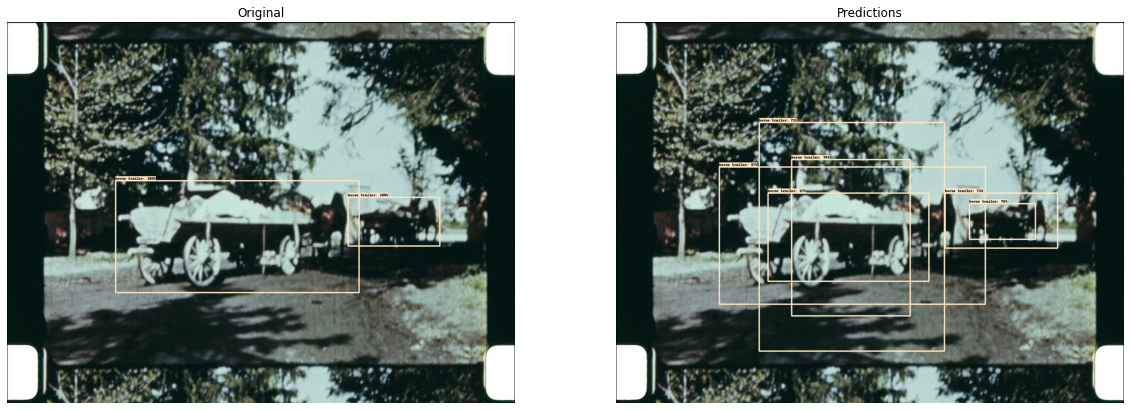

In [ ]:
idx = np.random.randint(len(test_df))

#Path to the image
image_path = test_df.filename[idx]
#generate predictions for the image
boxes, labels, scores = detect(image_path, threshold=0.60)

pred_image = draw_on_image(image_path, boxes, scores, labels)

real_image = load_image_from_data(test_df, index=idx)


fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(20,7))

ax1.imshow(real_image)
ax1.set_title("Original")
ax1.axis("off")

ax2.imshow(pred_image)
ax2.set_title("Predictions")
ax2.axis("off");

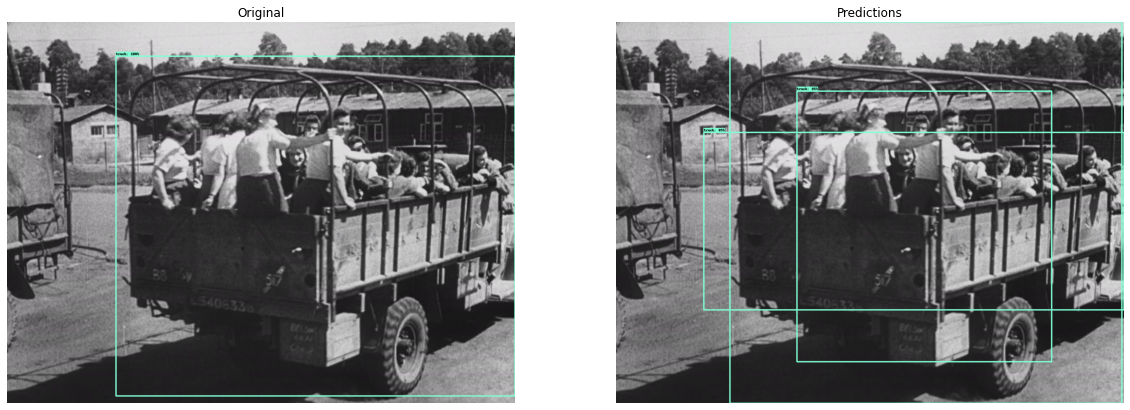

In [ ]:
idx = np.random.randint(len(test_df))

#Path to the image
image_path = test_df.filename[idx]
#generate predictions for the image
boxes, labels, scores = detect(image_path, threshold=0.60)

pred_image = draw_on_image(image_path, boxes, scores, labels)

real_image = load_image_from_data(test_df, index=idx)


fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(20,7))

ax1.imshow(real_image)
ax1.set_title("Original")
ax1.axis("off")

ax2.imshow(pred_image)
ax2.set_title("Predictions")
ax2.axis("off");